# Image (Face) Generation with Autoencoders

This project demonstrates the use of three different Autoencoder architectures to generate and reconstruct human faces from a dataset sourced from Hugging Face. The models include a basic linear Autoencoder, a Convolutional Autoencoder, and a Variational Autoencoder (VAE). Each model was trained to compress high-dimensional facial image data into lower-dimensional representations and then reconstruct the images from these compressed forms. The goal is to explore the effectiveness of different autoencoder designs in learning compact, meaningful representations of facial features, which can be used for tasks like image denoising, generation, or anomaly detection.


In [1]:
from datasets import load_dataset,DatasetDict
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import io
import os
from PIL import Image
import random
import torchvision.transforms as transforms
import utils
import torch.nn as nn
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from tqdm import tqdm
import time

/home/omar/TUM/05_projects/Image_generation_with_VAE/vae_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download and split the dataset into train,test and validation sets. 

In [2]:
ds = load_dataset("Karthik11232/human_face_generation")
#split the dataset 
train_test_set = ds['train'].train_test_split(test_size=0.1)
#print(train_test_set)
train_val_set = train_test_set['train'].train_test_split(test_size=0.1)

ds = DatasetDict({
    'train': train_test_set['train'],
    'test': train_test_set['test'],
    'validation': train_val_set['test']
})
#print (ds)
print(ds.shape)#complete dataset
print(train_test_set.shape)#train_val and test set
print(train_val_set.shape)#train val and test set

{'train': (2398, 1), 'test': (267, 1), 'validation': (240, 1)}
{'train': (2398, 1), 'test': (267, 1)}
{'train': (2158, 1), 'test': (240, 1)}


Save the datasets to disk

In [3]:
# Save the datasets to disk
output_dir = './human_face_generation_split/raw'
if not os.path.exists(output_dir):  #check if the directory already exists
    os.makedirs(output_dir, exist_ok=True)
# Save each split to disk
    utils.save_images(ds['train'], 'train',output_dir)
    utils.save_images(ds['validation'], 'validation',output_dir)
    utils.save_images(ds['test'], 'test',output_dir)

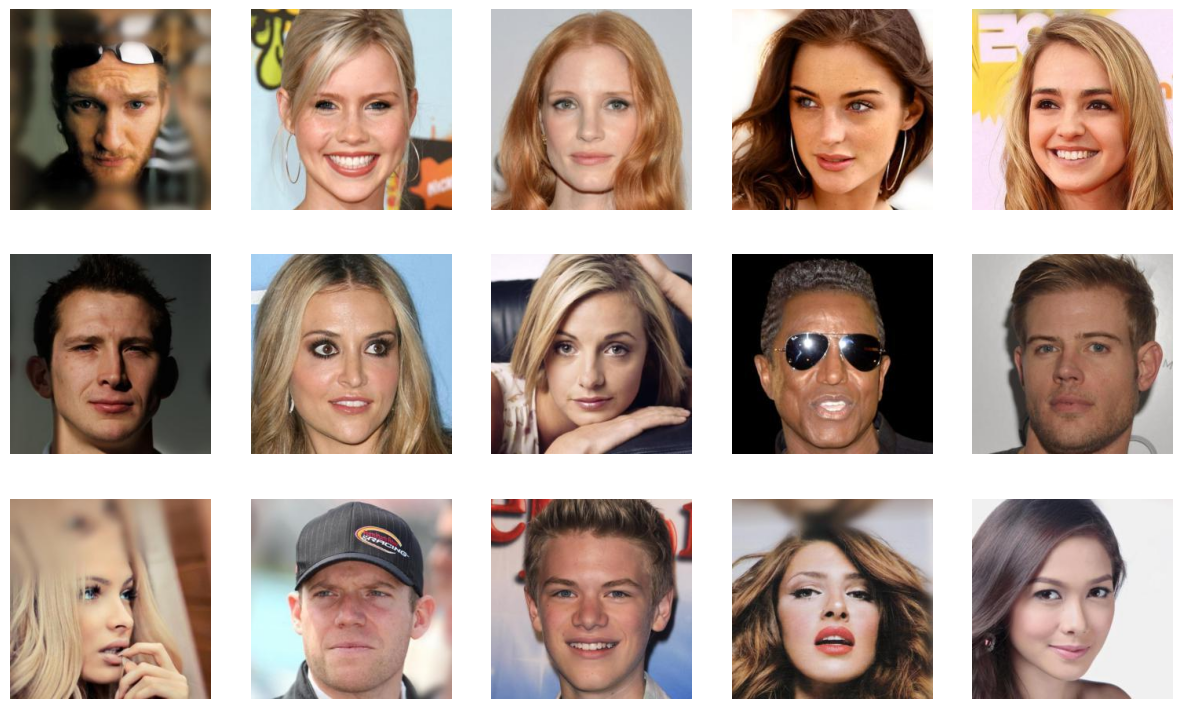

In [4]:
# Plot 15 random images in 3 rows and 5 columns
utils.plot_random_images(dataset_path='human_face_generation_split/raw/train', num_images=15, rows=3, cols=5)

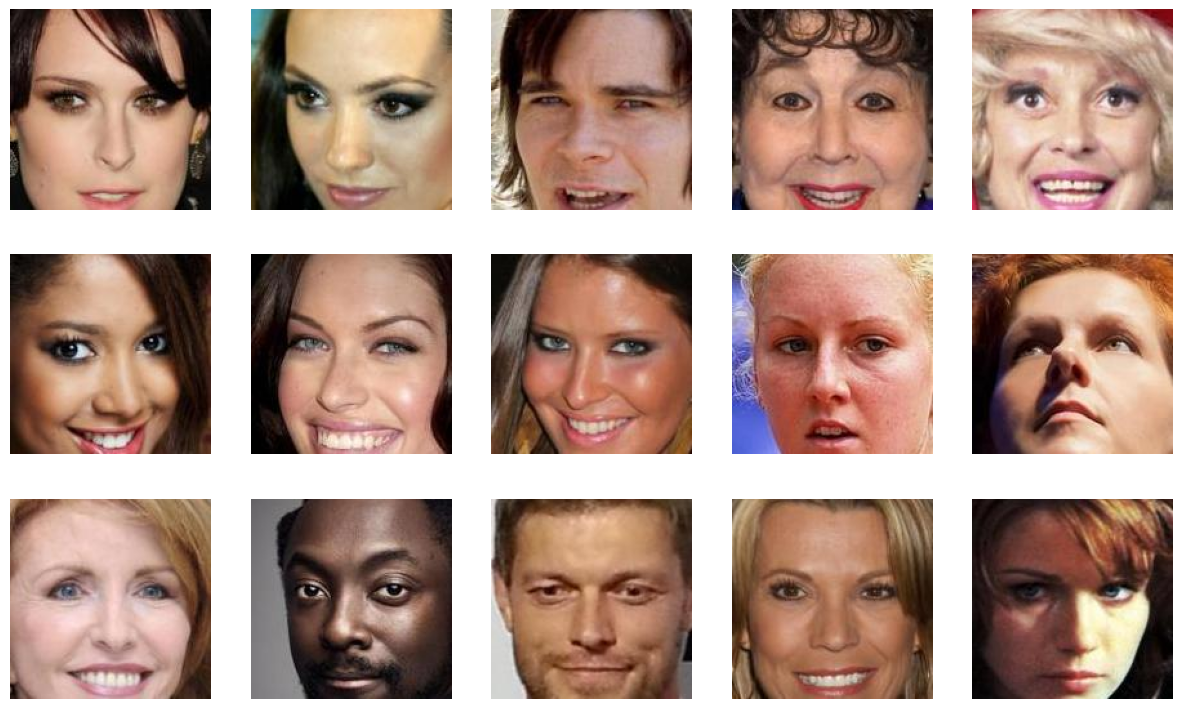

(156, 156)


In [5]:
# Prepoccessing 
preprocess = transforms.Compose([
    transforms.CenterCrop((156, 156)),  # Resize to a specific size if needed tried 200x200 was too big
    transforms.ToTensor(),          # Convert to tensor and normalize
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
preprocessed_output_dir = './human_face_generation_split/preprocessed'
os.makedirs(preprocessed_output_dir, exist_ok=True)
if True:#not os.path.exists(preprocessed_output_dir):#
# Save preprocessed training images

    utils.save_images(ds['train'], 'train', preprocessed_output_dir,preprocess=preprocess)
    utils.plot_random_images(os.path.join(preprocessed_output_dir, 'train'), num_images=15, rows=3, cols=5)
    img = Image.open("human_face_generation_split/preprocessed/train/image_2110.png")
    print(img.size)


In [36]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, img_size=156, flatten=False):
        """
        Args:
            image_folder (str): Path to the folder containing images.
            img_size (int): Size to which each image is resized.
            flatten (bool): Whether to flatten the image into a 1D array.
        """
        self.image_folder = image_folder
        self.img_size = img_size
        self.flatten = flatten
        self.images = os.listdir(image_folder)
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  # Resize images to img_size x img_size
            transforms.ToTensor()                    # Convert images to PyTorch tensors
        ])

    def __getitem__(self, idx):
        image_file = self.images[idx]
        image = Image.open(os.path.join(self.image_folder, image_file))
        image = self.transform(image)

        if self.flatten:
            image = np.array(image).reshape(-1,156*156) # Flatten the image into a 1D array

        return image

    def __len__(self):
        return len(self.images)
    
dataset_preprocessed = ImageDataset("human_face_generation_split/preprocessed/train")
dataset_preprocessed_lin = ImageDataset("human_face_generation_split/preprocessed/train",flatten=True)

dataset_val = ImageDataset("human_face_generation_split/raw/validation")
dataset_val_lin  = ImageDataset("human_face_generation_split/raw/validation",flatten=True)
dataset_test = ImageDataset("human_face_generation_split/raw/test")
show_dataset = ImageDataset("human_face_generation_split/show_imgs/train")
show_dataset_lin = ImageDataset("human_face_generation_split/show_imgs/train",flatten=True)

train_data = torch.utils.data.DataLoader(dataset_preprocessed,batch_size=16,shuffle=True)
train_data_lin = torch.utils.data.DataLoader(dataset_preprocessed_lin,batch_size=8,shuffle=True)
val_data_lin = torch.utils.data.DataLoader(dataset_val_lin)
val_data = torch.utils.data.DataLoader(dataset_val)
test_data = torch.utils.data.DataLoader(dataset_test)
show_data =torch.utils.data.DataLoader(show_dataset)
show_data_lin =torch.utils.data.DataLoader(show_dataset_lin)

# Linear Autoencoder

This autoencoder consists of linear layers with ReLU activation functions, designed to compress and reconstruct 50x50 pixel images. The model architecture includes three fully connected layers in both the encoder and decoder, with hidden layers of size 512. Xavier initialization is applied to the weights to ensure a good starting point for training. This initialization helps improve convergence and performance by maintaining the variance of the weights across layers.


In [6]:
class Autoencoder_linear(nn.Module):
    def __init__(self):
        super().__init__()
        self.size_hidden_layers = 512 
        self.encoder = nn.Sequential(
            nn.Linear(24336, 2048),  # Assuming 50x50 RGB images
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.size_hidden_layers),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(self.size_hidden_layers, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 24336),  # Output size to match original flattened image
            nn.ReLU(),  # Optionally use sigmoid to ensure output is in range [0, 1]
        )        
        # Apply weight initialization
        self.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward(self, x):
        # Flatten input
        #x = x.view(x.size(0), -1)  # Flatten input to shape (batch_size, 50*50*3)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [8]:
# Example usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# For Linear Autoencoder
linear_auto = Autoencoder_linear()
utils.train_autoencoder(linear_auto, train_data_lin, val_data_lin, device, epochs=101, lr=3e-4, ckpt_dir="human_face_generation_split", arch_name="lin", loss_fn="mse")


Epoch 1/101: 100%|██████████| 300/300 [00:36<00:00,  8.29batch/s, train_loss=0.0625]


Epoch 1/101 : train_loss = 0.0470, val_loss = 0.0448


Epoch 2/101: 100%|██████████| 300/300 [00:35<00:00,  8.45batch/s, train_loss=0.0273]


Epoch 2/101 : train_loss = 0.0205, val_loss = 0.0358


Epoch 3/101: 100%|██████████| 300/300 [00:34<00:00,  8.82batch/s, train_loss=0.0223]


Epoch 3/101 : train_loss = 0.0167, val_loss = 0.0327


Epoch 4/101: 100%|██████████| 300/300 [00:34<00:00,  8.66batch/s, train_loss=0.019] 


Epoch 4/101 : train_loss = 0.0142, val_loss = 0.0324


Epoch 5/101: 100%|██████████| 300/300 [00:35<00:00,  8.57batch/s, train_loss=0.018] 


Epoch 5/101 : train_loss = 0.0135, val_loss = 0.0283


Epoch 6/101: 100%|██████████| 300/300 [00:35<00:00,  8.47batch/s, train_loss=0.0165]


Epoch 6/101 : train_loss = 0.0124, val_loss = 0.0274


Epoch 7/101: 100%|██████████| 300/300 [00:35<00:00,  8.43batch/s, train_loss=0.016] 


Epoch 7/101 : train_loss = 0.0120, val_loss = 0.0271


Epoch 8/101: 100%|██████████| 300/300 [00:35<00:00,  8.51batch/s, train_loss=0.0151]


Epoch 8/101 : train_loss = 0.0113, val_loss = 0.0266


Epoch 9/101: 100%|██████████| 300/300 [00:36<00:00,  8.19batch/s, train_loss=0.0146]


Epoch 9/101 : train_loss = 0.0109, val_loss = 0.0275


Epoch 10/101: 100%|██████████| 300/300 [00:36<00:00,  8.23batch/s, train_loss=0.0139]


Epoch 10/101 : train_loss = 0.0105, val_loss = 0.0265


Epoch 11/101: 100%|██████████| 300/300 [00:35<00:00,  8.39batch/s, train_loss=0.0134] 


Epoch 11/101 : train_loss = 0.0100, val_loss = 0.0253


Epoch 12/101: 100%|██████████| 300/300 [00:35<00:00,  8.51batch/s, train_loss=0.0132] 


Epoch 12/101 : train_loss = 0.0099, val_loss = 0.0249


Epoch 13/101: 100%|██████████| 300/300 [00:35<00:00,  8.50batch/s, train_loss=0.0123] 


Epoch 13/101 : train_loss = 0.0092, val_loss = 0.0257


Epoch 14/101: 100%|██████████| 300/300 [00:35<00:00,  8.43batch/s, train_loss=0.0122] 


Epoch 14/101 : train_loss = 0.0092, val_loss = 0.0250


Epoch 15/101: 100%|██████████| 300/300 [00:36<00:00,  8.22batch/s, train_loss=0.0124] 


Epoch 15/101 : train_loss = 0.0093, val_loss = 0.0261


Epoch 16/101: 100%|██████████| 300/300 [00:36<00:00,  8.28batch/s, train_loss=0.0113] 


Epoch 16/101 : train_loss = 0.0085, val_loss = 0.0249


Epoch 17/101: 100%|██████████| 300/300 [00:36<00:00,  8.17batch/s, train_loss=0.0109] 


Epoch 17/101 : train_loss = 0.0082, val_loss = 0.0252


Epoch 18/101: 100%|██████████| 300/300 [00:35<00:00,  8.45batch/s, train_loss=0.0107] 


Epoch 18/101 : train_loss = 0.0080, val_loss = 0.0262


Epoch 19/101: 100%|██████████| 300/300 [00:37<00:00,  8.10batch/s, train_loss=0.0108] 


Epoch 19/101 : train_loss = 0.0081, val_loss = 0.0252


Epoch 20/101: 100%|██████████| 300/300 [00:35<00:00,  8.44batch/s, train_loss=0.0103] 


Epoch 20/101 : train_loss = 0.0077, val_loss = 0.0267


Epoch 21/101: 100%|██████████| 300/300 [00:36<00:00,  8.11batch/s, train_loss=0.01]   


Epoch 21/101 : train_loss = 0.0075, val_loss = 0.0264


Epoch 22/101: 100%|██████████| 300/300 [00:36<00:00,  8.30batch/s, train_loss=0.0095] 


Epoch 22/101 : train_loss = 0.0071, val_loss = 0.0253


Epoch 23/101: 100%|██████████| 300/300 [00:37<00:00,  8.07batch/s, train_loss=0.0092] 


Epoch 23/101 : train_loss = 0.0069, val_loss = 0.0255


Epoch 24/101: 100%|██████████| 300/300 [00:36<00:00,  8.13batch/s, train_loss=0.00919]


Epoch 24/101 : train_loss = 0.0069, val_loss = 0.0263


Epoch 25/101: 100%|██████████| 300/300 [00:35<00:00,  8.41batch/s, train_loss=0.00859]


Epoch 25/101 : train_loss = 0.0064, val_loss = 0.0258


Epoch 26/101: 100%|██████████| 300/300 [00:36<00:00,  8.21batch/s, train_loss=0.00881]


Epoch 26/101 : train_loss = 0.0066, val_loss = 0.0261


Epoch 27/101: 100%|██████████| 300/300 [00:36<00:00,  8.13batch/s, train_loss=0.00836]


Epoch 27/101 : train_loss = 0.0063, val_loss = 0.0266


Epoch 28/101: 100%|██████████| 300/300 [00:36<00:00,  8.22batch/s, train_loss=0.00812]


Epoch 28/101 : train_loss = 0.0061, val_loss = 0.0265


Epoch 29/101: 100%|██████████| 300/300 [00:35<00:00,  8.39batch/s, train_loss=0.00813]


Epoch 29/101 : train_loss = 0.0061, val_loss = 0.0260


Epoch 30/101: 100%|██████████| 300/300 [00:36<00:00,  8.17batch/s, train_loss=0.00745]


Epoch 30/101 : train_loss = 0.0056, val_loss = 0.0262


Epoch 31/101: 100%|██████████| 300/300 [00:36<00:00,  8.26batch/s, train_loss=0.00575]


Epoch 31/101 : train_loss = 0.0043, val_loss = 0.0254


Epoch 32/101: 100%|██████████| 300/300 [00:34<00:00,  8.59batch/s, train_loss=0.0054] 


Epoch 32/101 : train_loss = 0.0041, val_loss = 0.0252


Epoch 33/101: 100%|██████████| 300/300 [00:36<00:00,  8.30batch/s, train_loss=0.00527]


Epoch 33/101 : train_loss = 0.0040, val_loss = 0.0253


Epoch 34/101: 100%|██████████| 300/300 [00:36<00:00,  8.13batch/s, train_loss=0.00518]


Epoch 34/101 : train_loss = 0.0039, val_loss = 0.0252


Epoch 35/101: 100%|██████████| 300/300 [00:36<00:00,  8.14batch/s, train_loss=0.0051] 


Epoch 35/101 : train_loss = 0.0038, val_loss = 0.0252


Epoch 36/101: 100%|██████████| 300/300 [00:36<00:00,  8.15batch/s, train_loss=0.00504]


Epoch 36/101 : train_loss = 0.0038, val_loss = 0.0252


Epoch 37/101: 100%|██████████| 300/300 [00:36<00:00,  8.18batch/s, train_loss=0.00497]


Epoch 37/101 : train_loss = 0.0037, val_loss = 0.0252


Epoch 38/101: 100%|██████████| 300/300 [00:36<00:00,  8.28batch/s, train_loss=0.00492]


Epoch 38/101 : train_loss = 0.0037, val_loss = 0.0253


Epoch 39/101: 100%|██████████| 300/300 [00:36<00:00,  8.21batch/s, train_loss=0.00487]


Epoch 39/101 : train_loss = 0.0037, val_loss = 0.0254


Epoch 40/101: 100%|██████████| 300/300 [00:35<00:00,  8.39batch/s, train_loss=0.00481]


Epoch 40/101 : train_loss = 0.0036, val_loss = 0.0253


Epoch 41/101: 100%|██████████| 300/300 [00:34<00:00,  8.64batch/s, train_loss=0.00477]


Epoch 41/101 : train_loss = 0.0036, val_loss = 0.0253


Epoch 42/101: 100%|██████████| 300/300 [00:37<00:00,  8.05batch/s, train_loss=0.00472]


Epoch 42/101 : train_loss = 0.0035, val_loss = 0.0253


Epoch 43/101: 100%|██████████| 300/300 [00:36<00:00,  8.19batch/s, train_loss=0.00467]


Epoch 43/101 : train_loss = 0.0035, val_loss = 0.0253


Epoch 44/101: 100%|██████████| 300/300 [00:35<00:00,  8.35batch/s, train_loss=0.00462]


Epoch 44/101 : train_loss = 0.0035, val_loss = 0.0253


Epoch 45/101: 100%|██████████| 300/300 [00:36<00:00,  8.24batch/s, train_loss=0.00458]


Epoch 45/101 : train_loss = 0.0034, val_loss = 0.0253


Epoch 46/101: 100%|██████████| 300/300 [00:35<00:00,  8.47batch/s, train_loss=0.00454]


Epoch 46/101 : train_loss = 0.0034, val_loss = 0.0255


Epoch 47/101: 100%|██████████| 300/300 [00:35<00:00,  8.34batch/s, train_loss=0.0045] 


Epoch 47/101 : train_loss = 0.0034, val_loss = 0.0254


Epoch 48/101: 100%|██████████| 300/300 [00:37<00:00,  8.09batch/s, train_loss=0.00445]


Epoch 48/101 : train_loss = 0.0033, val_loss = 0.0256


Epoch 49/101: 100%|██████████| 300/300 [00:37<00:00,  8.08batch/s, train_loss=0.0044] 


Epoch 49/101 : train_loss = 0.0033, val_loss = 0.0255


Epoch 50/101: 100%|██████████| 300/300 [00:36<00:00,  8.26batch/s, train_loss=0.00437]


Epoch 50/101 : train_loss = 0.0033, val_loss = 0.0255


Epoch 51/101: 100%|██████████| 300/300 [00:36<00:00,  8.17batch/s, train_loss=0.00433]


Epoch 51/101 : train_loss = 0.0032, val_loss = 0.0256


Epoch 52/101: 100%|██████████| 300/300 [00:36<00:00,  8.25batch/s, train_loss=0.00429]


Epoch 52/101 : train_loss = 0.0032, val_loss = 0.0256


Epoch 53/101: 100%|██████████| 300/300 [00:37<00:00,  8.09batch/s, train_loss=0.00425]


Epoch 53/101 : train_loss = 0.0032, val_loss = 0.0257


Epoch 54/101: 100%|██████████| 300/300 [00:35<00:00,  8.40batch/s, train_loss=0.00421]


Epoch 54/101 : train_loss = 0.0032, val_loss = 0.0257


Epoch 55/101: 100%|██████████| 300/300 [00:35<00:00,  8.37batch/s, train_loss=0.00417]


Epoch 55/101 : train_loss = 0.0031, val_loss = 0.0257


Epoch 56/101: 100%|██████████| 300/300 [00:37<00:00,  8.10batch/s, train_loss=0.00413]


Epoch 56/101 : train_loss = 0.0031, val_loss = 0.0257


Epoch 57/101: 100%|██████████| 300/300 [00:37<00:00,  8.10batch/s, train_loss=0.0041] 


Epoch 57/101 : train_loss = 0.0031, val_loss = 0.0258


Epoch 58/101: 100%|██████████| 300/300 [00:35<00:00,  8.45batch/s, train_loss=0.00406]


Epoch 58/101 : train_loss = 0.0031, val_loss = 0.0258


Epoch 59/101: 100%|██████████| 300/300 [00:36<00:00,  8.23batch/s, train_loss=0.00403]


Epoch 59/101 : train_loss = 0.0030, val_loss = 0.0258


Epoch 60/101: 100%|██████████| 300/300 [00:36<00:00,  8.20batch/s, train_loss=0.004]  


Epoch 60/101 : train_loss = 0.0030, val_loss = 0.0259


Epoch 61/101: 100%|██████████| 300/300 [00:35<00:00,  8.49batch/s, train_loss=0.00384]


Epoch 61/101 : train_loss = 0.0029, val_loss = 0.0259


Epoch 62/101: 100%|██████████| 300/300 [00:35<00:00,  8.38batch/s, train_loss=0.00383]


Epoch 62/101 : train_loss = 0.0029, val_loss = 0.0258


Epoch 63/101: 100%|██████████| 300/300 [00:36<00:00,  8.12batch/s, train_loss=0.00382]


Epoch 63/101 : train_loss = 0.0029, val_loss = 0.0259


Epoch 64/101: 100%|██████████| 300/300 [00:35<00:00,  8.45batch/s, train_loss=0.00382]


Epoch 64/101 : train_loss = 0.0029, val_loss = 0.0259


Epoch 65/101: 100%|██████████| 300/300 [00:36<00:00,  8.11batch/s, train_loss=0.00381]


Epoch 65/101 : train_loss = 0.0029, val_loss = 0.0259


Epoch 66/101: 100%|██████████| 300/300 [00:36<00:00,  8.14batch/s, train_loss=0.00381]


Epoch 66/101 : train_loss = 0.0029, val_loss = 0.0259


Epoch 67/101: 100%|██████████| 300/300 [00:36<00:00,  8.24batch/s, train_loss=0.00381]


Epoch 67/101 : train_loss = 0.0029, val_loss = 0.0259


Epoch 68/101: 100%|██████████| 300/300 [00:37<00:00,  7.97batch/s, train_loss=0.0038] 


Epoch 68/101 : train_loss = 0.0029, val_loss = 0.0259


Epoch 69/101: 100%|██████████| 300/300 [00:37<00:00,  8.04batch/s, train_loss=0.0038] 


Epoch 69/101 : train_loss = 0.0029, val_loss = 0.0259


Epoch 70/101: 100%|██████████| 300/300 [00:36<00:00,  8.20batch/s, train_loss=0.00379]


Epoch 70/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 71/101: 100%|██████████| 300/300 [00:36<00:00,  8.14batch/s, train_loss=0.00379]


Epoch 71/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 72/101: 100%|██████████| 300/300 [00:36<00:00,  8.24batch/s, train_loss=0.00379]


Epoch 72/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 73/101: 100%|██████████| 300/300 [00:35<00:00,  8.37batch/s, train_loss=0.00378]


Epoch 73/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 74/101: 100%|██████████| 300/300 [00:35<00:00,  8.35batch/s, train_loss=0.00378]


Epoch 74/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 75/101: 100%|██████████| 300/300 [00:35<00:00,  8.45batch/s, train_loss=0.00378]


Epoch 75/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 76/101: 100%|██████████| 300/300 [00:37<00:00,  8.02batch/s, train_loss=0.00377]


Epoch 76/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 77/101: 100%|██████████| 300/300 [00:37<00:00,  8.05batch/s, train_loss=0.00377]


Epoch 77/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 78/101: 100%|██████████| 300/300 [00:35<00:00,  8.35batch/s, train_loss=0.00376]


Epoch 78/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 79/101: 100%|██████████| 300/300 [00:36<00:00,  8.18batch/s, train_loss=0.00376]


Epoch 79/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 80/101: 100%|██████████| 300/300 [00:36<00:00,  8.31batch/s, train_loss=0.00376]


Epoch 80/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 81/101: 100%|██████████| 300/300 [00:34<00:00,  8.59batch/s, train_loss=0.00375]


Epoch 81/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 82/101: 100%|██████████| 300/300 [00:36<00:00,  8.13batch/s, train_loss=0.00375]


Epoch 82/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 83/101: 100%|██████████| 300/300 [00:36<00:00,  8.24batch/s, train_loss=0.00375]


Epoch 83/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 84/101: 100%|██████████| 300/300 [00:35<00:00,  8.47batch/s, train_loss=0.00374]


Epoch 84/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 85/101: 100%|██████████| 300/300 [00:36<00:00,  8.23batch/s, train_loss=0.00374]


Epoch 85/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 86/101: 100%|██████████| 300/300 [00:35<00:00,  8.49batch/s, train_loss=0.00374]


Epoch 86/101 : train_loss = 0.0028, val_loss = 0.0259


Epoch 87/101: 100%|██████████| 300/300 [00:35<00:00,  8.40batch/s, train_loss=0.00373]


Epoch 87/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 88/101: 100%|██████████| 300/300 [00:35<00:00,  8.40batch/s, train_loss=0.00373]


Epoch 88/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 89/101: 100%|██████████| 300/300 [00:36<00:00,  8.28batch/s, train_loss=0.00372]


Epoch 89/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 90/101: 100%|██████████| 300/300 [00:35<00:00,  8.53batch/s, train_loss=0.00372]


Epoch 90/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 91/101: 100%|██████████| 300/300 [00:36<00:00,  8.22batch/s, train_loss=0.0037] 


Epoch 91/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 92/101: 100%|██████████| 300/300 [00:36<00:00,  8.28batch/s, train_loss=0.0037] 


Epoch 92/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 93/101: 100%|██████████| 300/300 [00:36<00:00,  8.27batch/s, train_loss=0.0037] 


Epoch 93/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 94/101: 100%|██████████| 300/300 [00:36<00:00,  8.24batch/s, train_loss=0.0037] 


Epoch 94/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 95/101: 100%|██████████| 300/300 [00:35<00:00,  8.34batch/s, train_loss=0.0037] 


Epoch 95/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 96/101: 100%|██████████| 300/300 [00:35<00:00,  8.39batch/s, train_loss=0.0037] 


Epoch 96/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 97/101: 100%|██████████| 300/300 [00:35<00:00,  8.37batch/s, train_loss=0.0037] 


Epoch 97/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 98/101: 100%|██████████| 300/300 [00:36<00:00,  8.14batch/s, train_loss=0.0037] 


Epoch 98/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 99/101: 100%|██████████| 300/300 [00:36<00:00,  8.27batch/s, train_loss=0.0037] 


Epoch 99/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 100/101: 100%|██████████| 300/300 [00:37<00:00,  8.07batch/s, train_loss=0.0037] 


Epoch 100/101 : train_loss = 0.0028, val_loss = 0.0260


Epoch 101/101: 100%|██████████| 300/300 [00:36<00:00,  8.29batch/s, train_loss=0.0037] 


Epoch 101/101 : train_loss = 0.0028, val_loss = 0.0260


cuda:0
Reconstructed Image 0 shape: (3, 24336)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0745046].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.11468526..1.1004962].


Reconstructed Image 1 shape: (3, 24336)
Reconstructed Image 2 shape: (3, 24336)
Reconstructed Image 3 shape: (3, 24336)
Reconstructed Image 4 shape: (3, 24336)


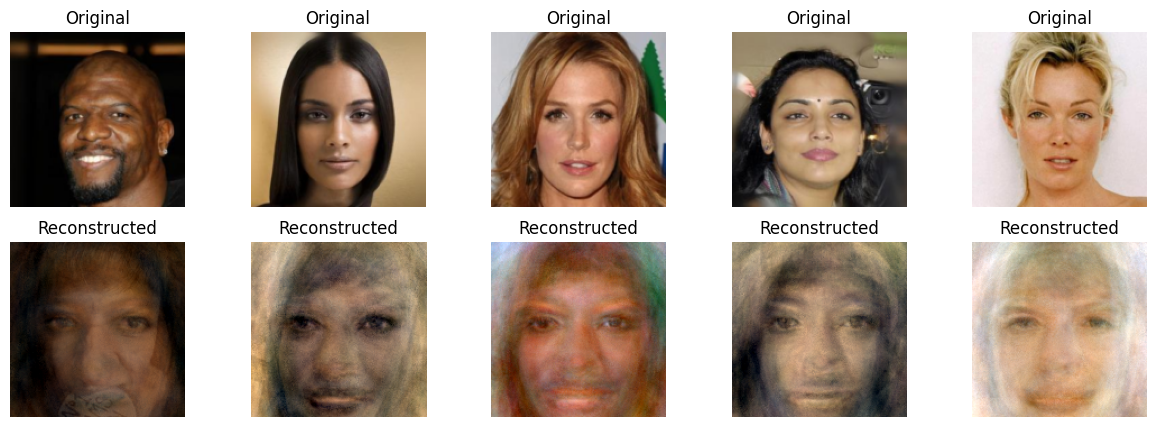

In [10]:
linear_auto = Autoencoder_linear()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#optimizer = torch.optim.Adam(linear_auto.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240905_155527_lin/checkpoint_epoch_21.pt", weights_only=True)
linear_auto.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['train_loss']
#linear_auto.eval()
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Assuming you want to plot 5 images
utils.plot_original_and_reconstructed(linear_auto, show_data_lin, num_images=5,device=device)


In [13]:
class Autoencoder_conv(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),  # 78x78
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),  # 40x40
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),  # 40x40
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),  # 40x40
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 78x78
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 156x156
            nn.Sigmoid()  # Assuming the input is normalized between [0, 1]
        )
    def forward(self,x):
            encoded = self.encoder(x)
            decoded = self.decoder(encoded)
            return encoded, decoded

In [14]:
conv_auto = Autoencoder_conv()  # Assuming you have this class defined
utils.train_autoencoder(conv_auto, train_data, val_data, device, epochs=101, lr=3e-4, ckpt_dir="human_face_generation_split", arch_name="conv", loss_fn="mse")


Epoch 1/101:   0%|          | 0/300 [00:00<?, ?batch/s]

Epoch 1/101: 100%|██████████| 300/300 [00:07<00:00, 41.83batch/s, train_loss=0.022] 


Epoch 1/101 : train_loss = 0.0165, val_loss = 0.0060


Epoch 2/101: 100%|██████████| 300/300 [00:05<00:00, 54.28batch/s, train_loss=0.00362]


Epoch 2/101 : train_loss = 0.0027, val_loss = 0.0031


Epoch 3/101: 100%|██████████| 300/300 [00:05<00:00, 52.94batch/s, train_loss=0.00269]


Epoch 3/101 : train_loss = 0.0020, val_loss = 0.0025


Epoch 4/101: 100%|██████████| 300/300 [00:05<00:00, 50.83batch/s, train_loss=0.00232]


Epoch 4/101 : train_loss = 0.0017, val_loss = 0.0022


Epoch 5/101: 100%|██████████| 300/300 [00:06<00:00, 44.56batch/s, train_loss=0.00203]


Epoch 5/101 : train_loss = 0.0015, val_loss = 0.0019


Epoch 6/101: 100%|██████████| 300/300 [00:14<00:00, 21.42batch/s, train_loss=0.00184]


Epoch 6/101 : train_loss = 0.0014, val_loss = 0.0018


Epoch 7/101: 100%|██████████| 300/300 [00:06<00:00, 45.61batch/s, train_loss=0.00168]


Epoch 7/101 : train_loss = 0.0013, val_loss = 0.0016


Epoch 8/101: 100%|██████████| 300/300 [00:13<00:00, 21.63batch/s, train_loss=0.00156]


Epoch 8/101 : train_loss = 0.0012, val_loss = 0.0015


Epoch 9/101: 100%|██████████| 300/300 [00:06<00:00, 43.00batch/s, train_loss=0.00145]


Epoch 9/101 : train_loss = 0.0011, val_loss = 0.0013


Epoch 10/101: 100%|██████████| 300/300 [00:15<00:00, 19.71batch/s, train_loss=0.0013]  


Epoch 10/101 : train_loss = 0.0010, val_loss = 0.0012


Epoch 11/101: 100%|██████████| 300/300 [00:06<00:00, 43.91batch/s, train_loss=0.00118] 


Epoch 11/101 : train_loss = 0.0009, val_loss = 0.0011


Epoch 12/101: 100%|██████████| 300/300 [00:11<00:00, 27.15batch/s, train_loss=0.00106] 


Epoch 12/101 : train_loss = 0.0008, val_loss = 0.0010


Epoch 13/101: 100%|██████████| 300/300 [00:06<00:00, 46.20batch/s, train_loss=0.000997]


Epoch 13/101 : train_loss = 0.0007, val_loss = 0.0009


Epoch 14/101: 100%|██████████| 300/300 [00:14<00:00, 20.51batch/s, train_loss=0.000944]


Epoch 14/101 : train_loss = 0.0007, val_loss = 0.0009


Epoch 15/101: 100%|██████████| 300/300 [00:06<00:00, 45.89batch/s, train_loss=0.000907]


Epoch 15/101 : train_loss = 0.0007, val_loss = 0.0008


Epoch 16/101: 100%|██████████| 300/300 [00:06<00:00, 43.86batch/s, train_loss=0.000893]


Epoch 16/101 : train_loss = 0.0007, val_loss = 0.0008


Epoch 17/101: 100%|██████████| 300/300 [00:08<00:00, 35.63batch/s, train_loss=0.000839]


Epoch 17/101 : train_loss = 0.0006, val_loss = 0.0008


Epoch 18/101: 100%|██████████| 300/300 [00:06<00:00, 47.63batch/s, train_loss=0.000857]


Epoch 18/101 : train_loss = 0.0006, val_loss = 0.0007


Epoch 19/101: 100%|██████████| 300/300 [00:06<00:00, 46.07batch/s, train_loss=0.000768]


Epoch 19/101 : train_loss = 0.0006, val_loss = 0.0007


Epoch 20/101: 100%|██████████| 300/300 [00:05<00:00, 50.04batch/s, train_loss=0.000759]


Epoch 20/101 : train_loss = 0.0006, val_loss = 0.0007


Epoch 21/101: 100%|██████████| 300/300 [00:06<00:00, 44.72batch/s, train_loss=0.000726]


Epoch 21/101 : train_loss = 0.0005, val_loss = 0.0007


Epoch 22/101: 100%|██████████| 300/300 [00:07<00:00, 39.33batch/s, train_loss=0.000717]


Epoch 22/101 : train_loss = 0.0005, val_loss = 0.0007


Epoch 23/101: 100%|██████████| 300/300 [00:07<00:00, 41.24batch/s, train_loss=0.000686]


Epoch 23/101 : train_loss = 0.0005, val_loss = 0.0007


Epoch 24/101: 100%|██████████| 300/300 [00:06<00:00, 44.06batch/s, train_loss=0.000674]


Epoch 24/101 : train_loss = 0.0005, val_loss = 0.0006


Epoch 25/101: 100%|██████████| 300/300 [00:06<00:00, 46.60batch/s, train_loss=0.000665]


Epoch 25/101 : train_loss = 0.0005, val_loss = 0.0006


Epoch 26/101: 100%|██████████| 300/300 [00:05<00:00, 53.42batch/s, train_loss=0.000666]


Epoch 26/101 : train_loss = 0.0005, val_loss = 0.0006


Epoch 27/101: 100%|██████████| 300/300 [00:07<00:00, 41.31batch/s, train_loss=0.000607]


Epoch 27/101 : train_loss = 0.0005, val_loss = 0.0006


Epoch 28/101: 100%|██████████| 300/300 [00:07<00:00, 38.86batch/s, train_loss=0.000613]


Epoch 28/101 : train_loss = 0.0005, val_loss = 0.0006


Epoch 29/101: 100%|██████████| 300/300 [00:06<00:00, 43.35batch/s, train_loss=0.000588]


Epoch 29/101 : train_loss = 0.0004, val_loss = 0.0006


Epoch 30/101: 100%|██████████| 300/300 [00:06<00:00, 44.36batch/s, train_loss=0.000576]


Epoch 30/101 : train_loss = 0.0004, val_loss = 0.0007


Epoch 31/101: 100%|██████████| 300/300 [00:06<00:00, 49.18batch/s, train_loss=0.000538]


Epoch 31/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 32/101: 100%|██████████| 300/300 [00:07<00:00, 40.32batch/s, train_loss=0.00053] 


Epoch 32/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 33/101: 100%|██████████| 300/300 [00:06<00:00, 48.12batch/s, train_loss=0.000528]


Epoch 33/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 34/101: 100%|██████████| 300/300 [00:06<00:00, 46.46batch/s, train_loss=0.000525]


Epoch 34/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 35/101: 100%|██████████| 300/300 [00:07<00:00, 41.53batch/s, train_loss=0.000523]


Epoch 35/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 36/101: 100%|██████████| 300/300 [00:07<00:00, 42.51batch/s, train_loss=0.00052] 


Epoch 36/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 37/101: 100%|██████████| 300/300 [00:07<00:00, 40.91batch/s, train_loss=0.000516]


Epoch 37/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 38/101: 100%|██████████| 300/300 [00:07<00:00, 38.74batch/s, train_loss=0.000513]


Epoch 38/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 39/101: 100%|██████████| 300/300 [00:07<00:00, 41.03batch/s, train_loss=0.000509]


Epoch 39/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 40/101: 100%|██████████| 300/300 [00:06<00:00, 48.29batch/s, train_loss=0.000505]


Epoch 40/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 41/101: 100%|██████████| 300/300 [00:06<00:00, 48.28batch/s, train_loss=0.000501]


Epoch 41/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 42/101: 100%|██████████| 300/300 [00:06<00:00, 44.39batch/s, train_loss=0.000497]


Epoch 42/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 43/101: 100%|██████████| 300/300 [00:08<00:00, 37.35batch/s, train_loss=0.000493]


Epoch 43/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 44/101: 100%|██████████| 300/300 [00:05<00:00, 50.15batch/s, train_loss=0.000488]


Epoch 44/101 : train_loss = 0.0004, val_loss = 0.0005


Epoch 45/101: 100%|██████████| 300/300 [00:05<00:00, 51.26batch/s, train_loss=0.000484]


Epoch 45/101 : train_loss = 0.0004, val_loss = 0.0004


Epoch 46/101: 100%|██████████| 300/300 [00:05<00:00, 51.10batch/s, train_loss=0.000479]


Epoch 46/101 : train_loss = 0.0004, val_loss = 0.0004


Epoch 47/101: 100%|██████████| 300/300 [00:07<00:00, 39.63batch/s, train_loss=0.000475]


Epoch 47/101 : train_loss = 0.0004, val_loss = 0.0004


Epoch 48/101: 100%|██████████| 300/300 [00:06<00:00, 48.62batch/s, train_loss=0.000471]


Epoch 48/101 : train_loss = 0.0004, val_loss = 0.0004


Epoch 49/101: 100%|██████████| 300/300 [00:07<00:00, 38.16batch/s, train_loss=0.000467]


Epoch 49/101 : train_loss = 0.0004, val_loss = 0.0004


Epoch 50/101: 100%|██████████| 300/300 [00:05<00:00, 50.36batch/s, train_loss=0.000463]


Epoch 50/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 51/101: 100%|██████████| 300/300 [00:07<00:00, 37.95batch/s, train_loss=0.000458]


Epoch 51/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 52/101: 100%|██████████| 300/300 [00:06<00:00, 49.57batch/s, train_loss=0.000455]


Epoch 52/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 53/101: 100%|██████████| 300/300 [00:06<00:00, 49.75batch/s, train_loss=0.000451]


Epoch 53/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 54/101: 100%|██████████| 300/300 [00:05<00:00, 51.82batch/s, train_loss=0.000447]


Epoch 54/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 55/101: 100%|██████████| 300/300 [00:06<00:00, 47.05batch/s, train_loss=0.000443]


Epoch 55/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 56/101: 100%|██████████| 300/300 [00:05<00:00, 50.62batch/s, train_loss=0.00044] 


Epoch 56/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 57/101: 100%|██████████| 300/300 [00:06<00:00, 44.36batch/s, train_loss=0.000437]


Epoch 57/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 58/101: 100%|██████████| 300/300 [00:08<00:00, 34.96batch/s, train_loss=0.000434]


Epoch 58/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 59/101: 100%|██████████| 300/300 [00:07<00:00, 42.28batch/s, train_loss=0.00043] 


Epoch 59/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 60/101: 100%|██████████| 300/300 [00:08<00:00, 34.54batch/s, train_loss=0.000427]


Epoch 60/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 61/101: 100%|██████████| 300/300 [00:06<00:00, 49.21batch/s, train_loss=0.000424]


Epoch 61/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 62/101: 100%|██████████| 300/300 [00:05<00:00, 56.79batch/s, train_loss=0.000424]


Epoch 62/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 63/101: 100%|██████████| 300/300 [00:06<00:00, 46.23batch/s, train_loss=0.000423]


Epoch 63/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 64/101: 100%|██████████| 300/300 [00:06<00:00, 47.08batch/s, train_loss=0.000423]


Epoch 64/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 65/101: 100%|██████████| 300/300 [00:07<00:00, 38.64batch/s, train_loss=0.000422]


Epoch 65/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 66/101: 100%|██████████| 300/300 [00:06<00:00, 45.22batch/s, train_loss=0.000422]


Epoch 66/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 67/101: 100%|██████████| 300/300 [00:08<00:00, 36.60batch/s, train_loss=0.000421]


Epoch 67/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 68/101: 100%|██████████| 300/300 [00:06<00:00, 47.00batch/s, train_loss=0.000421]


Epoch 68/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 69/101: 100%|██████████| 300/300 [00:06<00:00, 44.24batch/s, train_loss=0.00042] 


Epoch 69/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 70/101: 100%|██████████| 300/300 [00:08<00:00, 37.43batch/s, train_loss=0.00042] 


Epoch 70/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 71/101: 100%|██████████| 300/300 [00:07<00:00, 40.10batch/s, train_loss=0.000419]


Epoch 71/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 72/101: 100%|██████████| 300/300 [00:07<00:00, 40.85batch/s, train_loss=0.000419]


Epoch 72/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 73/101: 100%|██████████| 300/300 [00:06<00:00, 46.33batch/s, train_loss=0.000418]


Epoch 73/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 74/101: 100%|██████████| 300/300 [00:08<00:00, 37.29batch/s, train_loss=0.000417]


Epoch 74/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 75/101: 100%|██████████| 300/300 [00:06<00:00, 48.50batch/s, train_loss=0.000417]


Epoch 75/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 76/101: 100%|██████████| 300/300 [00:06<00:00, 46.29batch/s, train_loss=0.000416]


Epoch 76/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 77/101: 100%|██████████| 300/300 [00:08<00:00, 36.78batch/s, train_loss=0.000416]


Epoch 77/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 78/101: 100%|██████████| 300/300 [00:06<00:00, 47.44batch/s, train_loss=0.000415]


Epoch 78/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 79/101: 100%|██████████| 300/300 [00:07<00:00, 40.43batch/s, train_loss=0.000414]


Epoch 79/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 80/101: 100%|██████████| 300/300 [00:06<00:00, 43.97batch/s, train_loss=0.000414]


Epoch 80/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 81/101: 100%|██████████| 300/300 [00:06<00:00, 43.36batch/s, train_loss=0.000413]


Epoch 81/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 82/101: 100%|██████████| 300/300 [00:08<00:00, 34.93batch/s, train_loss=0.000413]


Epoch 82/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 83/101: 100%|██████████| 300/300 [00:06<00:00, 46.49batch/s, train_loss=0.000412]


Epoch 83/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 84/101: 100%|██████████| 300/300 [00:06<00:00, 47.68batch/s, train_loss=0.000411]


Epoch 84/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 85/101: 100%|██████████| 300/300 [00:08<00:00, 36.76batch/s, train_loss=0.000411]


Epoch 85/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 86/101: 100%|██████████| 300/300 [00:07<00:00, 42.27batch/s, train_loss=0.00041] 


Epoch 86/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 87/101: 100%|██████████| 300/300 [00:06<00:00, 43.15batch/s, train_loss=0.00041] 


Epoch 87/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 88/101: 100%|██████████| 300/300 [00:05<00:00, 53.36batch/s, train_loss=0.000409]


Epoch 88/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 89/101: 100%|██████████| 300/300 [00:05<00:00, 51.50batch/s, train_loss=0.000409]


Epoch 89/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 90/101: 100%|██████████| 300/300 [00:06<00:00, 43.56batch/s, train_loss=0.000408]


Epoch 90/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 91/101: 100%|██████████| 300/300 [00:05<00:00, 53.34batch/s, train_loss=0.000408]


Epoch 91/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 92/101: 100%|██████████| 300/300 [00:05<00:00, 52.83batch/s, train_loss=0.000408]


Epoch 92/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 93/101: 100%|██████████| 300/300 [00:05<00:00, 50.44batch/s, train_loss=0.000407]


Epoch 93/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 94/101: 100%|██████████| 300/300 [00:07<00:00, 38.73batch/s, train_loss=0.000407]


Epoch 94/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 95/101: 100%|██████████| 300/300 [00:07<00:00, 40.98batch/s, train_loss=0.000407]


Epoch 95/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 96/101: 100%|██████████| 300/300 [00:06<00:00, 43.00batch/s, train_loss=0.000407]


Epoch 96/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 97/101: 100%|██████████| 300/300 [00:06<00:00, 47.44batch/s, train_loss=0.000407]


Epoch 97/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 98/101: 100%|██████████| 300/300 [00:06<00:00, 47.35batch/s, train_loss=0.000407]


Epoch 98/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 99/101: 100%|██████████| 300/300 [00:06<00:00, 48.28batch/s, train_loss=0.000407]


Epoch 99/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 100/101: 100%|██████████| 300/300 [00:06<00:00, 44.29batch/s, train_loss=0.000407]


Epoch 100/101 : train_loss = 0.0003, val_loss = 0.0004


Epoch 101/101: 100%|██████████| 300/300 [00:07<00:00, 42.35batch/s, train_loss=0.000407]


Epoch 101/101 : train_loss = 0.0003, val_loss = 0.0004


cuda:0
Reconstructed Image 0 shape: (3, 156, 156)
Reconstructed Image 1 shape: (3, 156, 156)
Reconstructed Image 2 shape: (3, 156, 156)
Reconstructed Image 3 shape: (3, 156, 156)
Reconstructed Image 4 shape: (3, 156, 156)


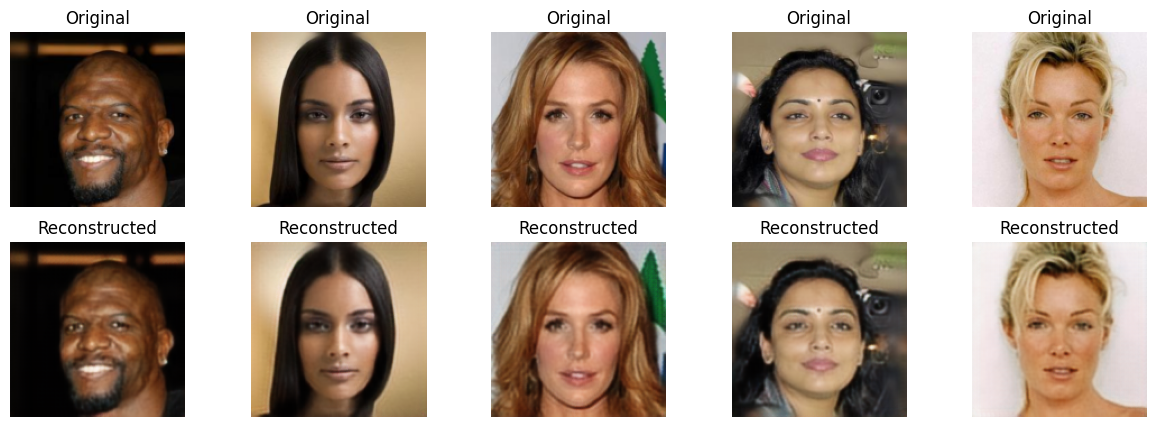

In [15]:
auto_conv = Autoencoder_conv()
optimizer = torch.optim.Adam(auto_conv.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240905_171854_conv/checkpoint_epoch_101.pt", weights_only=True)
auto_conv.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch torchvision.ckpoint['epoch']
#loss = checkpoint['train_loss']
#linear_auto.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Assuming you want to plot 5 images
utils.plot_original_and_reconstructed(auto_conv, show_data, num_images=5,device=device)

In [35]:
import gc

vae.cpu()
del vae
gc.collect()
torch.cuda.empty_cache()

In [37]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),  # 78x78
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=2),  # 40x40
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),  # 40x40
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),  # 40x40
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=2, output_padding=1),  # 78x78
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 156x156
            nn.Sigmoid()  # Assuming the input is normalized between [0, 1]
        )
        
        # Adjust based on the correct flattened size from encoder
   # Latent space
        self.fc1 = nn.Linear(64*40*40, 64)  # Map to latent mean
        self.fc2 = nn.Linear(64*40*40, 64)  # Map to latent logvar
        self.fc3 = nn.Linear(64, 64*40*40)  # Map back from latent space to decoder input
        self.apply(self.init_weights)

    @staticmethod
    def init_weights(m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.1)

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # Flatten for the linear layers

        mean = self.fc1(x)
        logvar = self.fc2(x)
        return mean, logvar

    def reparameterization(self, mean, logvar):
        #std = torch.exp(0.5 * logvar)

        epsilon = torch.randn_like(logvar).to(device)      
        z = mean + logvar*epsilon
        return z


    def decode(self, z):
        z = self.fc3(z)
        z = z.view(z.size(0), 64, 40, 40)  # Reshape to the dimensions expected by the decoder
        x_hat = self.decoder(z)
        return x_hat


    def forward(self, x):
        #x=self.encode(x)
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [38]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
   # print(f'Reconstruction Loss: {reproduction_loss.item()}, KL Divergence: {KLD.item()}')

    return reproduction_loss + KLD


In [39]:
# For Variational Autoencoder (VAE)
vae = VAE()  # Assuming you have this class defined
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
utils.train_autoencoder(vae, train_data, val_data, device, epochs=101, lr=3e-4, 
                        ckpt_dir="human_face_generation_split", arch_name="vae", loss_fn="vae")

Epoch 1/101: 100%|██████████| 150/150 [00:08<00:00, 17.49batch/s, train_loss=5.26e+4]


Epoch 1/101 : train_loss = 46041.7108, val_loss = 3388.6216


Epoch 2/101: 100%|██████████| 150/150 [00:08<00:00, 18.06batch/s, train_loss=2.48e+4]


Epoch 2/101 : train_loss = 21724.1141, val_loss = 2354.5992


Epoch 3/101: 100%|██████████| 150/150 [00:08<00:00, 17.73batch/s, train_loss=1.87e+4]


Epoch 3/101 : train_loss = 16358.1457, val_loss = 2003.6360


Epoch 4/101: 100%|██████████| 150/150 [00:08<00:00, 17.63batch/s, train_loss=1.62e+4]


Epoch 4/101 : train_loss = 14208.8835, val_loss = 1779.9715


Epoch 5/101: 100%|██████████| 150/150 [00:10<00:00, 14.88batch/s, train_loss=1.45e+4]


Epoch 5/101 : train_loss = 12729.6767, val_loss = 1670.9363


Epoch 6/101: 100%|██████████| 150/150 [00:10<00:00, 14.28batch/s, train_loss=1.33e+4]


Epoch 6/101 : train_loss = 11686.9349, val_loss = 1535.9443


Epoch 7/101: 100%|██████████| 150/150 [00:10<00:00, 14.07batch/s, train_loss=1.25e+4]


Epoch 7/101 : train_loss = 10954.9892, val_loss = 1442.8071


Epoch 8/101: 100%|██████████| 150/150 [00:10<00:00, 14.74batch/s, train_loss=1.18e+4]


Epoch 8/101 : train_loss = 10311.9362, val_loss = 1383.3012


Epoch 9/101: 100%|██████████| 150/150 [00:10<00:00, 14.15batch/s, train_loss=1.12e+4]


Epoch 9/101 : train_loss = 9767.2568, val_loss = 1324.1497


Epoch 10/101: 100%|██████████| 150/150 [00:11<00:00, 13.34batch/s, train_loss=1.08e+4]


Epoch 10/101 : train_loss = 9458.0514, val_loss = 1282.3904


Epoch 11/101: 100%|██████████| 150/150 [00:10<00:00, 14.87batch/s, train_loss=1.02e+4]


Epoch 11/101 : train_loss = 8960.1826, val_loss = 1253.2579


Epoch 12/101: 100%|██████████| 150/150 [00:11<00:00, 13.33batch/s, train_loss=9.83e+3]


Epoch 12/101 : train_loss = 8605.5996, val_loss = 1229.1319


Epoch 13/101: 100%|██████████| 150/150 [00:10<00:00, 14.05batch/s, train_loss=9.53e+3]


Epoch 13/101 : train_loss = 8344.8103, val_loss = 1206.2340


Epoch 14/101: 100%|██████████| 150/150 [00:10<00:00, 13.89batch/s, train_loss=9.3e+3] 


Epoch 14/101 : train_loss = 8144.0951, val_loss = 1194.6496


Epoch 15/101: 100%|██████████| 150/150 [00:10<00:00, 14.49batch/s, train_loss=9.09e+3]


Epoch 15/101 : train_loss = 7958.3400, val_loss = 1187.5100


Epoch 16/101: 100%|██████████| 150/150 [00:10<00:00, 14.52batch/s, train_loss=8.89e+3]


Epoch 16/101 : train_loss = 7787.8101, val_loss = 1176.7934


Epoch 17/101: 100%|██████████| 150/150 [00:11<00:00, 13.18batch/s, train_loss=8.75e+3]


Epoch 17/101 : train_loss = 7662.9727, val_loss = 1181.4094


Epoch 18/101: 100%|██████████| 150/150 [00:11<00:00, 13.14batch/s, train_loss=8.64e+3]


Epoch 18/101 : train_loss = 7564.4935, val_loss = 1187.5861


Epoch 19/101: 100%|██████████| 150/150 [00:10<00:00, 14.23batch/s, train_loss=8.51e+3]


Epoch 19/101 : train_loss = 7454.2887, val_loss = 1204.3342


Epoch 20/101: 100%|██████████| 150/150 [00:11<00:00, 13.35batch/s, train_loss=8.39e+3]


Epoch 20/101 : train_loss = 7348.4444, val_loss = 1190.6163


Epoch 21/101: 100%|██████████| 150/150 [00:10<00:00, 13.72batch/s, train_loss=8.3e+3] 


Epoch 21/101 : train_loss = 7266.2974, val_loss = 1202.2723


Epoch 22/101: 100%|██████████| 150/150 [00:10<00:00, 14.93batch/s, train_loss=8.19e+3]


Epoch 22/101 : train_loss = 7175.7746, val_loss = 1196.5379


Epoch 23/101: 100%|██████████| 150/150 [00:10<00:00, 14.73batch/s, train_loss=8.09e+3]


Epoch 23/101 : train_loss = 7080.8776, val_loss = 1216.4238


Epoch 24/101: 100%|██████████| 150/150 [00:09<00:00, 15.69batch/s, train_loss=8.01e+3]


Epoch 24/101 : train_loss = 7016.4227, val_loss = 1213.2630


Epoch 25/101: 100%|██████████| 150/150 [00:10<00:00, 14.39batch/s, train_loss=7.93e+3]


Epoch 25/101 : train_loss = 6945.1752, val_loss = 1219.2762


Epoch 26/101: 100%|██████████| 150/150 [00:08<00:00, 17.49batch/s, train_loss=7.81e+3]


Epoch 26/101 : train_loss = 6842.8897, val_loss = 1234.8455


Epoch 27/101: 100%|██████████| 150/150 [00:10<00:00, 13.81batch/s, train_loss=7.77e+3]


Epoch 27/101 : train_loss = 6807.6197, val_loss = 1224.6410


Epoch 28/101: 100%|██████████| 150/150 [00:09<00:00, 15.14batch/s, train_loss=7.68e+3]


Epoch 28/101 : train_loss = 6722.8419, val_loss = 1235.6623


Epoch 29/101: 100%|██████████| 150/150 [00:08<00:00, 16.99batch/s, train_loss=7.54e+3]


Epoch 29/101 : train_loss = 6603.0886, val_loss = 1235.9100


Epoch 30/101: 100%|██████████| 150/150 [00:10<00:00, 14.26batch/s, train_loss=7.47e+3]


Epoch 30/101 : train_loss = 6541.6760, val_loss = 1262.0169


Epoch 31/101: 100%|██████████| 150/150 [00:10<00:00, 13.95batch/s, train_loss=7.06e+3]


Epoch 31/101 : train_loss = 6184.8841, val_loss = 1229.4778


Epoch 32/101: 100%|██████████| 150/150 [00:11<00:00, 13.11batch/s, train_loss=6.96e+3]


Epoch 32/101 : train_loss = 6094.0585, val_loss = 1231.6138


Epoch 33/101: 100%|██████████| 150/150 [00:11<00:00, 13.08batch/s, train_loss=6.91e+3]


Epoch 33/101 : train_loss = 6050.7832, val_loss = 1234.8505


Epoch 34/101: 100%|██████████| 150/150 [00:09<00:00, 15.77batch/s, train_loss=6.88e+3]


Epoch 34/101 : train_loss = 6022.3754, val_loss = 1234.2229


Epoch 35/101: 100%|██████████| 150/150 [00:10<00:00, 14.44batch/s, train_loss=6.85e+3]


Epoch 35/101 : train_loss = 5997.7006, val_loss = 1236.5304


Epoch 36/101: 100%|██████████| 150/150 [00:11<00:00, 13.62batch/s, train_loss=6.83e+3]


Epoch 36/101 : train_loss = 5978.6013, val_loss = 1238.3697


Epoch 37/101: 100%|██████████| 150/150 [00:08<00:00, 17.58batch/s, train_loss=6.81e+3]


Epoch 37/101 : train_loss = 5961.0381, val_loss = 1240.9094


Epoch 38/101: 100%|██████████| 150/150 [00:08<00:00, 18.59batch/s, train_loss=6.79e+3]


Epoch 38/101 : train_loss = 5941.9051, val_loss = 1241.3577


Epoch 39/101: 100%|██████████| 150/150 [00:10<00:00, 14.42batch/s, train_loss=6.77e+3]


Epoch 39/101 : train_loss = 5924.4977, val_loss = 1242.7430


Epoch 40/101: 100%|██████████| 150/150 [00:09<00:00, 15.04batch/s, train_loss=6.75e+3]


Epoch 40/101 : train_loss = 5909.4987, val_loss = 1247.8826


Epoch 41/101: 100%|██████████| 150/150 [00:09<00:00, 15.22batch/s, train_loss=6.73e+3]


Epoch 41/101 : train_loss = 5893.7275, val_loss = 1246.3431


Epoch 42/101: 100%|██████████| 150/150 [00:10<00:00, 13.81batch/s, train_loss=6.71e+3]


Epoch 42/101 : train_loss = 5876.1356, val_loss = 1250.1196


Epoch 43/101: 100%|██████████| 150/150 [00:12<00:00, 11.88batch/s, train_loss=6.69e+3]


Epoch 43/101 : train_loss = 5862.4628, val_loss = 1251.9139


Epoch 44/101: 100%|██████████| 150/150 [00:11<00:00, 13.51batch/s, train_loss=6.68e+3]


Epoch 44/101 : train_loss = 5846.7715, val_loss = 1255.4038


Epoch 45/101: 100%|██████████| 150/150 [00:11<00:00, 13.06batch/s, train_loss=6.66e+3]


Epoch 45/101 : train_loss = 5831.2919, val_loss = 1256.8327


Epoch 46/101: 100%|██████████| 150/150 [00:10<00:00, 14.27batch/s, train_loss=6.64e+3]


Epoch 46/101 : train_loss = 5815.0491, val_loss = 1259.1529


Epoch 47/101: 100%|██████████| 150/150 [00:10<00:00, 13.91batch/s, train_loss=6.62e+3]


Epoch 47/101 : train_loss = 5800.6358, val_loss = 1257.4576


Epoch 48/101: 100%|██████████| 150/150 [00:10<00:00, 14.04batch/s, train_loss=6.61e+3]


Epoch 48/101 : train_loss = 5784.2281, val_loss = 1262.9675


Epoch 49/101: 100%|██████████| 150/150 [00:10<00:00, 14.68batch/s, train_loss=6.59e+3]


Epoch 49/101 : train_loss = 5767.5369, val_loss = 1264.6275


Epoch 50/101: 100%|██████████| 150/150 [00:10<00:00, 14.19batch/s, train_loss=6.57e+3]


Epoch 50/101 : train_loss = 5752.8879, val_loss = 1271.8403


Epoch 51/101: 100%|██████████| 150/150 [00:11<00:00, 13.57batch/s, train_loss=6.55e+3]


Epoch 51/101 : train_loss = 5740.1453, val_loss = 1268.8261


Epoch 52/101: 100%|██████████| 150/150 [00:11<00:00, 13.12batch/s, train_loss=6.53e+3]


Epoch 52/101 : train_loss = 5721.1454, val_loss = 1274.0423


Epoch 53/101: 100%|██████████| 150/150 [00:11<00:00, 12.83batch/s, train_loss=6.51e+3]


Epoch 53/101 : train_loss = 5704.9872, val_loss = 1273.3579


Epoch 54/101: 100%|██████████| 150/150 [00:11<00:00, 13.54batch/s, train_loss=6.5e+3] 


cuda:0
Reconstructed Image 0 shape: (3, 50, 50)
Reconstructed Image 1 shape: (3, 50, 50)
Reconstructed Image 2 shape: (3, 50, 50)
Reconstructed Image 3 shape: (3, 50, 50)
Reconstructed Image 4 shape: (3, 50, 50)


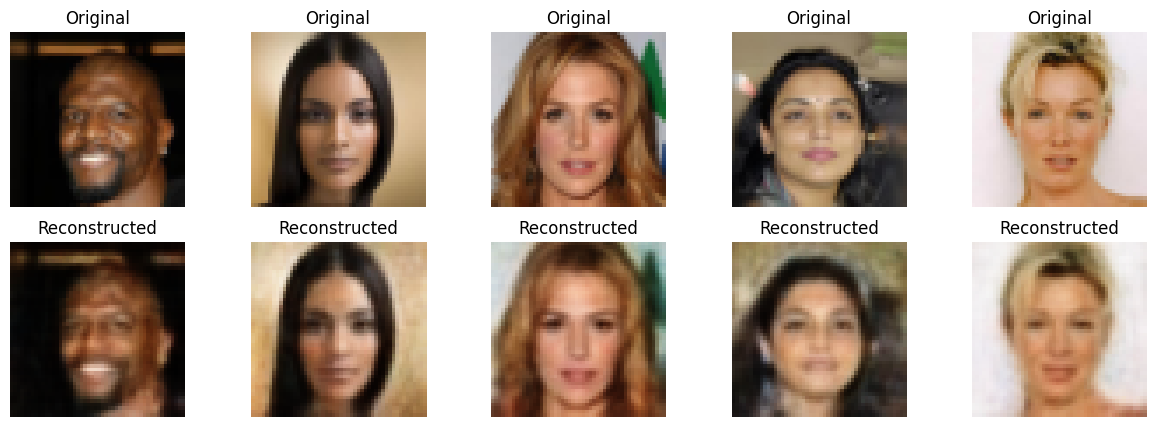

In [50]:
vae = VAE()
#optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)
checkpoint = torch.load("human_face_generation_split/20240904_231525_vae/checkpoint_epoch_101.pt", weights_only=True)
vae.load_state_dict(checkpoint['state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch torchvision.ckpoint['epoch']
#loss = checkpoint['train_loss']
#linear_auto.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
utils.plot_original_and_reconstructed(vae, show_data,device, num_images=5)

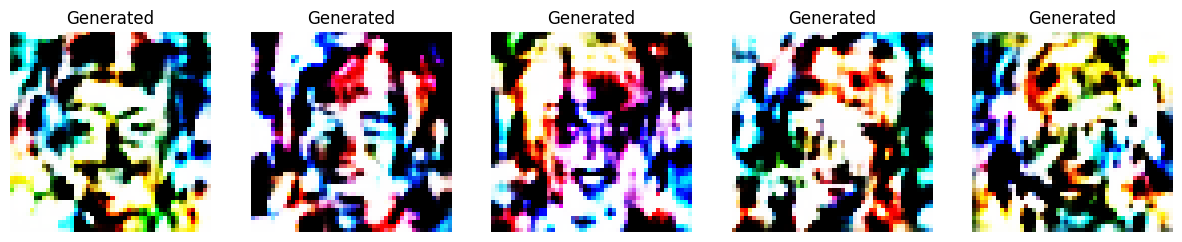

In [52]:
def generate_new_images_vae(model, num_images, latent_dim, device):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Sample from the standard normal distribution
        z = torch.randn(num_images, latent_dim).to(device)
        
        # Pass through the decoder part of the VAE
        generated_images = model.decode(z)  # Ensure your VAE has a decode method

        # Move tensors back to CPU for visualization
        generated_images = generated_images.cpu().numpy()

    # Plot the generated images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i].transpose(1, 2, 0))  # Transpose for RGB display
        plt.title("Generated")
        plt.axis('off')
    
    plt.show()

# Assuming your VAE has a latent dimension of 512
generate_new_images_vae(vae, num_images=5, latent_dim=512, device=device)